In [1]:
import inspect # view the source code using ---> getsourcelines(thing)

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import random

In [2]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 1.10.2
torchvision version: 0.11.0a0


In [25]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

class_names = train_data.classes
print(class_names)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [483]:
len(train_data.data), len(test_data.data)

(60000, 10000)

In [4]:
# iterator example

for x in np.random.rand(5): print(x)

print(), print()

stuff = np.random.rand(5)
print(stuff), print()
it = iter(stuff)

while True:
    try:
        item = next(it)
        print(item)
    except StopIteration:
        print("StopIteration exception raised")
        break
        

stuff = np.random.rand(5)
print(), print(), print(stuff), print()
it = iter(stuff)

# this will raise exception
#while True:
#    item = next(it)
#    print(item)

0.7489037135271945
0.2359374185249561
0.35079946187476685
0.33193568370709214
0.7711700322227103


[0.64120886 0.7227911  0.59870808 0.53980997 0.21483179]

0.6412088626472018
0.722791097236152
0.5987080831171033
0.5398099713960205
0.21483178787892587
StopIteration exception raised


[0.62926763 0.04868002 0.48315002 0.14514478 0.92150382]



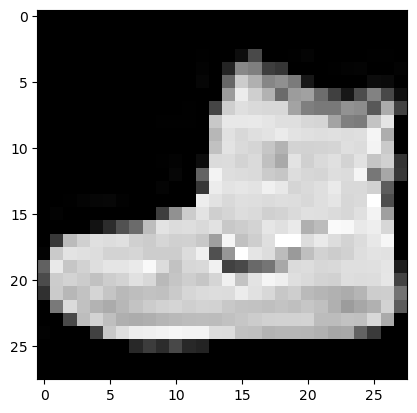

In [5]:
image, label = train_data[0]
image = image.detach().numpy()
plt.imshow(image.squeeze(), cmap="gray")

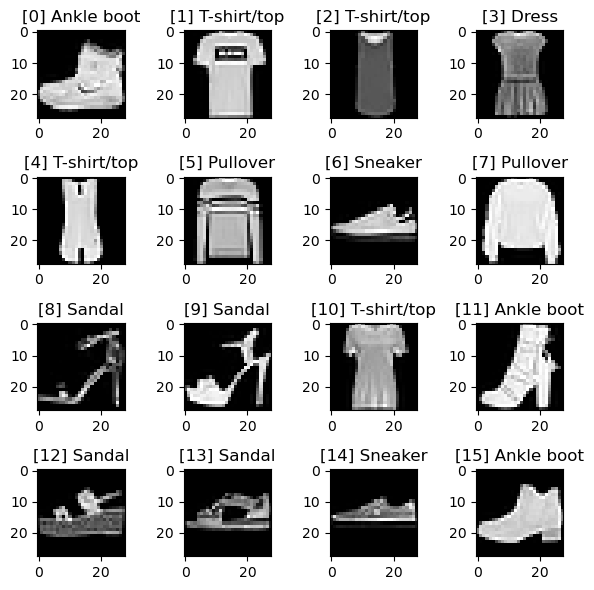

In [6]:
rows, cols = 4, 4
fig = plt.figure(figsize=(6,6))
for i in range(rows * cols):
    image, label = train_data[i]
    image = image.detach().numpy().squeeze()
    fig.add_subplot(rows, cols, i+1)
    plt.imshow(image, cmap="gray")
    plt.title(f"[{i}] {train_data.classes[label]}")
fig.tight_layout()

In [7]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch? 
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x12eb39ac0>, <torch.utils.data.dataloader.DataLoader object at 0x12eb39700>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [8]:
a = iter(train_dataloader)

b[0] (batch of samples, length: 32)
Each sized: torch.Size([1, 28, 28])

b[1] (batch of labels, length: 32): 
tensor([8, 1, 8, 9, 4, 2, 0, 7, 0, 1, 2, 8, 2, 3, 0, 0, 6, 8, 2, 7, 3, 3, 9, 5,
        7, 6, 7, 2, 0, 7, 1, 7])

b[1][0] (current label: 8), type: <class 'numpy.ndarray'>


Text(0.5, 1.0, '8, Bag')

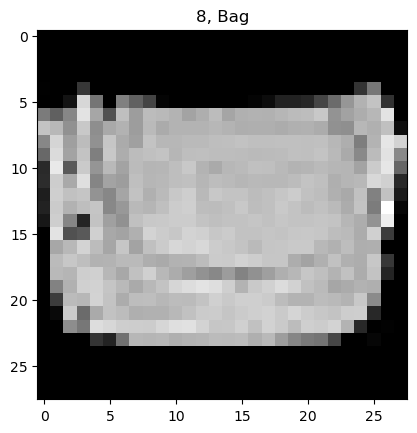

In [9]:
b = next(a)

print(f"b[0] (batch of samples, length: {len(b[0])})\nEach sized: {b[0][0].shape}\n")
print(f"b[1] (batch of labels, length: {len(b[1])}): \n{b[1]}\n")

# next(a)
# [0] (e.g. train_features_batch)
#    ---> array of tensors (X data),   length: batch size
# [1] (e.g. train_labels_batch)
#    ---> array of tensors (y labels), length: batch size

# second index: current sample in current batch

img = b[0][0].detach().numpy().squeeze()
lab = b[1][0].detach().numpy()
print(f"b[1][0] (current label: {lab}), type: {type(lab)}")

plt.imshow(img, cmap="gray")
plt.title(f"{lab}, {train_data.classes[lab]}")

In [10]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [20]:
flatten_model = nn.Flatten()

x = train_features_batch[0]

output = flatten_model(x)

print(f"shape before flatten: {x.shape}      -> [colour channels, height, width]")
print(f"shape after flatten:  {output.shape} -> [colour channels, height*width]")

shape before flatten: torch.Size([1, 28, 28])      -> [colour channels, height, width]
shape after flatten:  torch.Size([1, 784]) -> [colour channels, height*width]


In [139]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # will take 28x28 image and output 28*28 (784) vector
            nn.Linear(in_features=input_shape, out_features=hidden_units), # will take 784 vector as input (input_shape arg)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [170]:
torch.manual_seed(42)

model_0 = FashionMNISTModelV0(input_shape=28*28, hidden_units=10, output_shape=len(class_names))
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [171]:
def accuracy_fn(y_pred, y_true):
    #prediction_index = y_pred.detach().numpy().argmax(axis=1)
    #true_index = y_true.detach().numpy()
    # must be converted before the function
    l = len(y_true)
    return np.sum(y_pred==y_true)/l

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [172]:
test_batch = next(iter(test_dataloader))
test_batch_samples = test_batch[0]
test_batch_labels = test_batch[1]


print(len(test_batch))

model_0.eval()
with torch.inference_mode():
    
    preds = model_0(test_batch_samples)

    print(preds.shape)
    
    loss = loss_fn(preds, test_batch_labels)
    print(loss.item())
    
    acc = accuracy_fn(y_pred=preds.detach().numpy().argmax(axis=1), y_true=test_batch_labels.detach().numpy())
    print(acc)
    
preds_np = preds.detach().numpy().argmax(axis=1)
trues_np = test_batch_labels.detach().numpy()

print(preds_np.shape, trues_np.shape)
    
print(f"predictions: {preds_np}")

print(f"true vals  : {trues_np}")

print(f"accuracy   : {accuracy_fn(y_pred=preds_np, y_true=trues_np)}")
    



print(),print(),print()
preds = preds[0].detach().numpy().argmax()
print(preds)
labels = test_batch_labels[0].detach().numpy()
print(labels)



2
torch.Size([32, 10])
2.290891647338867
0.09375
(32,) (32,)
predictions: [2 6 6 4 4 6 7 4 2 6 4 2 7 4 4 4 4 6 6 4 4 7 6 6 4 7 4 6 6 4 1 1]
true vals  : [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8]
accuracy   : 0.09375



2
9


In [176]:
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n----------")
    
    train_loss = 0
    
    # n_batch is the current batch
    # (X, y) since train_dataloader has 2 items - data and labels, both are tensor arrays
    for n_batch, (X, y) in enumerate(train_dataloader):
        
        y_pred = model_0(X)
        
        loss = loss_fn(y_pred, y)
        
        train_loss += loss # accumulate loss for each epoch
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        if n_batch % 400 == 0:
            print(f"Looked at {n_batch * len(X)}/{len(train_dataloader.dataset)} samples")
            
    train_loss /= len(train_dataloader) # get train loss percentage
    
    losses, accuracies = [], []
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            
            loss = loss_fn(test_pred, y)
            
            test_loss += loss
            
            test_acc += accuracy_fn(y_pred=test_pred.detach().numpy().argmax(axis=1), y_true=y.detach().numpy())
            #accuracies.append(test_acc)
            a = test_acc/len(test_dataloader)*100
            #print(a)
            accuracies.append(a)
        
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        #accuracies.append(test_acc*100)

  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Epoch: 0
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 33%|█████████████████████▋                                           | 1/3 [00:01<00:03,  1.74s/it]

Epoch: 1
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 67%|███████████████████████████████████████████▎                     | 2/3 [00:03<00:01,  1.72s/it]

Epoch: 2
----------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:05<00:00,  1.72s/it]


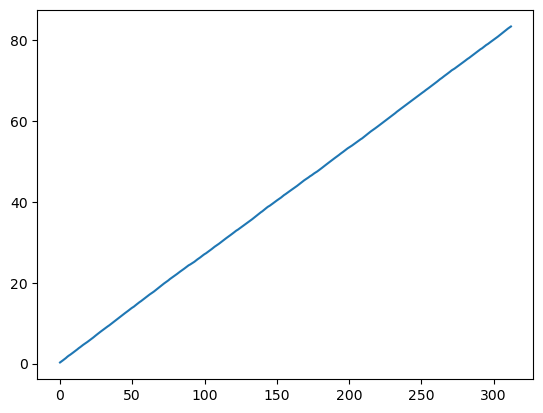

In [177]:
plt.plot(accuracies)

In [182]:
print(test_acc*100) # accuracy percentage
print(test_loss)

83.4564696485623
tensor(0.4610)


In [319]:
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader, # samples & labels batches for testing
                loss_fn: torch.nn.Module,
                accuracy_fn,
                should_plot: bool):
    
    losses, accuracies = [], []
    
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            
            predictions = model(X)
            
            loss = loss_fn(predictions, y)
            losses.append(loss.item())
            
            acc = accuracy_fn(predictions.detach().numpy().argmax(axis=1), y.detach().numpy())*100
            accuracies.append(acc)           
    
    last_loss = losses[len(losses)-1]
    last_acc = accuracies[len(accuracies)-1]
    
    if should_plot:
        plt.plot(accuracies, c='b')
        plt.plot([*range(len(accuracies))], [np.mean(accuracies) for _ in range(len(accuracies))], c="r")
        plt.plot(np.exp(losses), c='g')
        plt.show()
        
        print(f"Loss: {last_loss}")
        print(f"Accuracy: {last_acc}")
    
    return {"model_name": model.__class__.__name__,
            "model_loss": last_loss,
            "model_accuracy": last_acc}

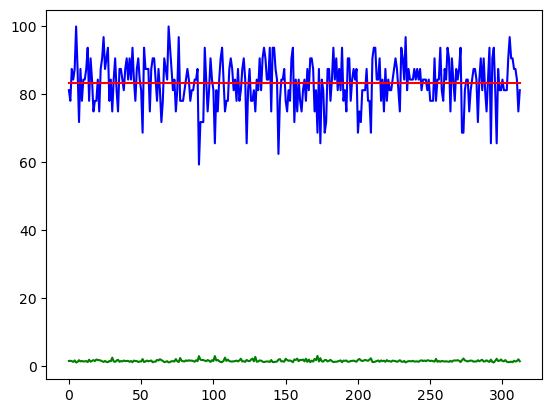

Loss: 0.40090563893318176
Accuracy: 81.25
{'model_name': 'FashionMNISTModelV0', 'model_loss': 0.40090563893318176, 'model_accuracy': 81.25}


In [429]:
loss_fn = nn.CrossEntropyLoss()
model_0_results = eval_model(model_0, test_dataloader, loss_fn, accuracy_fn, True)
print(model_0_results)

In [488]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
        
    def forward(self, x):
        return self.layer_stack(x)

In [489]:
def train_model(model: nn.Module,
                loss_fn,
                optimizer, 
                dataloader: torch.utils.data.DataLoader,
                n_epochs: int,
                batch_size: int):
  
    losses = []
    accuracies = []
    
    model.train()
    
    for epoch in tqdm(range(n_epochs)):
        
        print(f"Epoch: {epoch}/{n_epochs}---------------")
    
        for batch_n, (X, y) in enumerate(dataloader):
            
            if batch_n % 500 == 0: print(f"Batch: {batch_n}/{len(dataloader)}---------------")

            y_predictions = model(X)
            
            loss = loss_fn(y_predictions, y)
            losses.append(loss.item())

            acc = accuracy_fn(y_predictions.detach().numpy().argmax(axis=1), y.detach().numpy())*100
            accuracies.append(acc)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
                
    plt.plot(accuracies)
    plt.plot(np.exp(losses))
    plt.ylim(0, 100)
    plt.show()
    print(f"Accuracy: {accuracies[len(accuracies)-1]}")
    print(f"Loss: {losses[len(losses)-1]}")

In [490]:
model_1 = FashionMNISTModelV1(28*28, 10, len(class_names))

In [491]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Epoch: 0/3---------------
Batch: 0/1875---------------
Batch: 500/1875---------------
Batch: 1000/1875---------------
Batch: 1500/1875---------------


 33%|█████████████████████▋                                           | 1/3 [00:01<00:03,  1.69s/it]

Epoch: 1/3---------------
Batch: 0/1875---------------
Batch: 500/1875---------------
Batch: 1000/1875---------------
Batch: 1500/1875---------------


 67%|███████████████████████████████████████████▎                     | 2/3 [00:03<00:01,  1.64s/it]

Epoch: 2/3---------------
Batch: 0/1875---------------
Batch: 500/1875---------------
Batch: 1000/1875---------------
Batch: 1500/1875---------------


100%|█████████████████████████████████████████████████████████████████| 3/3 [00:04<00:00,  1.63s/it]


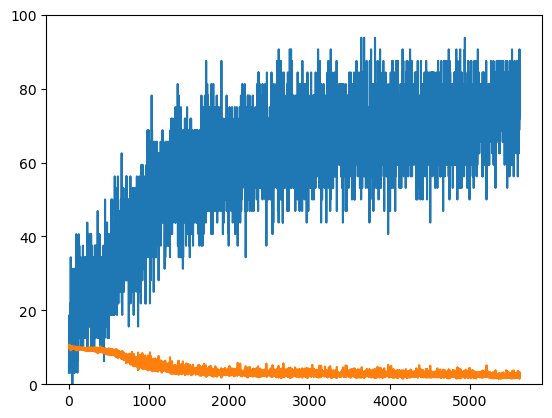

Accuracy: 75.0
Loss: 0.7951974868774414


In [492]:
train_model(model_1, loss_fn, optimizer, train_dataloader, 3, 32)

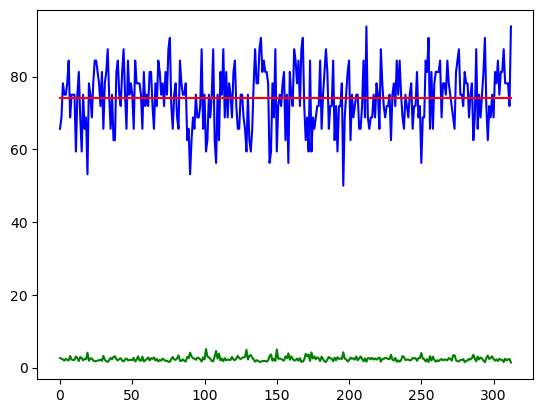

Loss: 0.33107781410217285
Accuracy: 93.75


{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.33107781410217285,
 'model_accuracy': 93.75}

In [493]:
model_1_results = eval_model(model_1, test_dataloader, loss_fn, accuracy_fn, True)
model_1_results

In [494]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.40090563893318176,
 'model_accuracy': 81.25}

In [547]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the window going over the image
                      stride=1,      # default
                      padding=1),    # # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x) #x.shape = torch.Size([32, 10, 14, 14])
        x = self.block_2(x) #x.shape = torch.Size([32, 10, 7, 7])
        x = self.classifier(x) #x.shape = torch.Size([32, 10])
        return x

In [548]:
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names))
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [549]:
test_batch = next(iter(test_dataloader))
test_batch_samples = test_batch[0]
test_batch_labels = test_batch[1]

print(len(test_batch))

model_2.eval()
with torch.inference_mode():
    
    preds = model_2(test_batch_samples)
    
    preds_np = preds.detach().numpy()
    print(f"Test predictions: {preds_np.argmax(axis=1)}")  
    print(f"Test labels     : {test_batch_labels.detach().numpy()}")
    
    loss = loss_fn(preds, test_batch_labels)
    print(f"Loss: {loss.item()}")
    
    acc = accuracy_fn(y_pred=preds_np.argmax(axis=1),y_true=test_batch_labels.detach().numpy())*100
    print(f"Accuracy: {acc}")


2
Test predictions: [3 8 8 3 3 8 8 8 3 3 3 3 3 8 3 3 3 3 3 6 3 3 3 3 8 3 8 8 3 8 3 8]
Test labels     : [9 2 1 1 6 1 4 6 5 7 4 5 7 3 4 1 2 4 8 0 2 5 7 9 1 4 6 0 9 3 8 8]
Loss: 2.305589437484741
Accuracy: 3.125


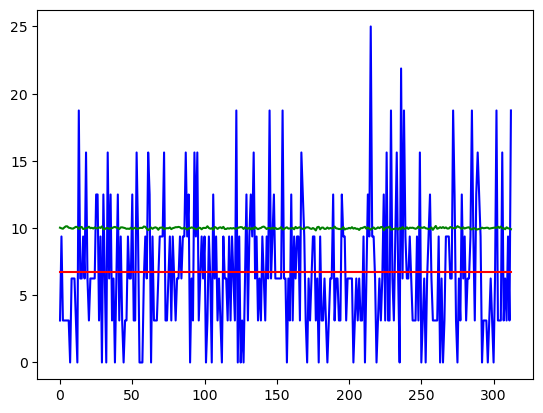

Loss: 2.2943835258483887
Accuracy: 18.75


{'model_name': 'FashionMNISTModelV2',
 'model_loss': 2.2943835258483887,
 'model_accuracy': 18.75}

In [550]:
eval_model(model_2, test_dataloader, loss_fn, accuracy_fn, True)
            